This code imports essential libraries for machine learning and natural language processing:

- **PyTorch**: For building and training neural networks.
  
- **Transformers**: For tokenization and using BERT in NLP tasks.

- **Scikit-learn**: For data management and model evaluation.

- **Pandas**: For data manipulation.

- **NumPy**: For numerical operations.

- **Random and tqdm**: For randomness and progress bar support.

- **Matplotlib**: For data visualization.

- **NLTK**: For text processing and handling stop words.

- **Regex and String**: For string manipulation and text cleaning.

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import string
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import gc

This section initializes the environment for reproducibility and device selection:

- A fixed **SEED** is set to ensure consistent results across runs.
- **Random seeds** for PyTorch, NumPy, and the built-in random module are defined to maintain the same state.
- The **device** is set to use GPU if available; otherwise, it defaults to CPU, optimizing performance for model training.

In [78]:

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

- The dataset is read into a DataFrame using `pd.read_csv()`.
- The `toclean_text` function removes punctuation from the text.
- An **abbreviations dictionary** is defined to replace common abbreviations with their full forms.

Multiple cleaning functions are created to:
- Remove URLs (`remove_URL`)
- Remove HTML tags (`remove_HTML`)
- Remove non-ASCII characters (`remove_not_ASCII`)
- Replace abbreviations in the text (`replace_abbrev`)
- Remove mentions (e.g., usernames) (`remove_mention`)
- Remove numbers (`remove_number`)
- Remove emojis (`remove_emoji`)
- Transcribe specific emoticons to labels (sad, smile, heart)

The `clean_tweet` function combines all cleaning steps, and the DataFrame's text column is processed using this function. Finally, it retains only the 'text' and 'target' columns and drops any missing values.

In [79]:

df = pd.read_csv("train.csv")
def toclean_text(text):
    clean_text = [char for char in text if char not in string.punctuation]
    clean_text = ''.join(clean_text)        
    return clean_text

df['text'] = df['text'].apply(toclean_text)



abbreviations = {
    "$" : " dollar ",
    "‚Ç¨" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}


def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    return smiley.sub(r'SMILE', text)

def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

def clean_tweet(text):
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
  
    return text

df["text"] = df["text"].apply(clean_tweet)
df = df[['text', 'target']].dropna()

In this part of the code, we set up tokenization using the BERT tokenizer. First, we initialize the **BertTokenizer** with the "bert-base-uncased" pre-trained model, which helps in converting our text into tokens that the BERT model can understand. 

We define a maximum sequence length of 128 tokens, ensuring that each text is uniformly processed. 

The `tokenize_text` function is then created to handle the list of text: it takes the text, truncates them if they exceed the maximum length, and pads them to ensure consistency. Finally, it returns the tokenized text as PyTorch tensors, making them ready for input into the BERT model for further processing.

In [80]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 128

def tokenize_text(text):
    return tokenizer(
        text.tolist(),
        truncation=True,
        padding='max_length',
        max_length=MAX_LEN,
        return_tensors='pt'
    )

we define a custom dataset class, **TweetDataset**, for handling our tokenized tweet data. 

The class is initialized with the token encodings and their corresponding labels. It implements the following methods:

- The `__init__` method stores the encodings and labels for use later.
- The `__len__` method returns the number of samples in the dataset.
- The `__getitem__` method retrieves the input IDs and attention masks for a specific index, as well as the corresponding label as a PyTorch tensor.

This custom dataset allows seamless integration with PyTorch's DataLoader for batching and shuffling during model training.

In [81]:

class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

we split the dataset into training and validation sets. Using the `train_test_split` function, we separate 20% of the data for validation while retaining 80% for training. The splitting is done based on the fixed random seed to ensure reproducibility.

Next, we tokenize the training and validation text using the `tokenize_text` function, which prepares the text for BERT input.

We then create instances of the **TweetDataset** for both training and validation sets, passing in the corresponding encodings and labels. 

Finally, we initialize **DataLoaders** for both datasets, setting a batch size of 32 for training (with shuffling enabled) and 64 for validation, allowing efficient loading of data during model training and evaluation.

In [82]:
train_text, val_text, train_labels, val_labels = train_test_split(
    df['text'], df['target'], test_size=0.2, random_state=SEED
)

train_encodings = tokenize_text(train_text)
val_encodings = tokenize_text(val_text)

train_dataset = TweetDataset(train_encodings, train_labels.tolist())
val_dataset = TweetDataset(val_encodings, val_labels.tolist())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

we define a custom classifier model called **LSTM or GRU_Classifier** that combines BERT with a recurrent neural network (RNN), specifically LSTM or GRU.

The model's initialization (`__init__` method) includes:

- Loading the BERT model as a feature extractor and freezing its weights to prevent updates during training.
- Accepting parameters such as the type of RNN (default is LSTM), the hidden dimension size, dropout rate, and whether the RNN is bidirectional.
- Depending on the specified RNN type, either an LSTM or GRU layer is initialized, along with a dropout layer for regularization and a fully connected layer for classification into two classes.

The `forward` method processes the input by passing it through BERT, obtaining the last hidden states. The outputs are then masked according to the attention mask, packed into the RNN, and processed to obtain the final hidden state, which is dropped out and passed through the fully connected layer to produce class predictions.

This structure allows the model to capture sequential dependencies with the RNN while utilizing the powerful contextual embeddings from BERT.

In [83]:
class LSTM_and_GRU_Classifier(nn.Module):
    def __init__(self, rnn_type='lstm', hidden_dim=128, dropout=0.3, bidirectional=True):
        super(LSTM_and_GRU_Classifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.bert.eval()  # Use BERT as feature extractor (freeze weights)

        for param in self.bert.parameters():
            param.requires_grad = False

        self.rnn_type = rnn_type.lower()
        self.bidirectional = bidirectional
        self.hidden_dim = hidden_dim
        input_dim = self.bert.config.hidden_size

        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=bidirectional)
        else:
            raise ValueError("Invalid rnn_type")

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), 2)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = bert_out.last_hidden_state  # shape: [batch_size, seq_len, 768]
        x = x * attention_mask.unsqueeze(-1)

        packed_out, hidden = self.rnn(x)

        if isinstance(hidden, tuple):  # LSTM
            hidden = hidden[0]

        if self.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        x = self.dropout(hidden)
        return self.fc(x)


we define the **train** function to handle the training process of the model. 

The function begins by setting the model to training mode and initializing a variable to track the total loss. It then iterates over the provided data loader, processing each batch of data. For each batch:

- The input IDs, attention masks, and labels are transferred to the specified device (GPU or CPU).
- The optimizer's gradients are reset with `optimizer.zero_grad()`.
- The model predicts outputs based on the input data.
- The loss is calculated using cross-entropy between the predicted outputs and the true labels.
- Backpropagation is performed through `loss.backward()`, and the optimizer updates the model parameters with `optimizer.step()`.
- The loss for the batch is accumulated.

Finally, the function returns the average loss for all batches, providing a measure of the model's performance during the training epoch.

In [84]:
def train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

we define the **evaluate** function, which is responsible for assessing the model's performance on a validation or test dataset.

The function starts by setting the model to evaluation mode and initializing lists to store all predicted and true labels. It processes each batch in the data loader without tracking gradients (using `torch.no_grad()`).

For each batch:
- Input IDs, attention masks, and labels are moved to the appropriate device.
- The model generates predictions based on the input data.
- Predicted class labels are obtained by taking the argmax of the output logits.

These predictions and true labels are extended into their respective lists for later comparison. If the `printPrediction` flag is set to true, detailed prediction results for each sample are printed.


In [85]:
def evaluate(model, dataloader, device, printPrediction=False):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    if printPrediction :
        print("üßæ Prediction Results:")
        for i, (pred, true_label) in enumerate(zip(all_preds, all_labels)):
            print(f"Sample {i+1}: Predicted = {pred}, Actual = {true_label}")

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy


we define the **run_experiment** function to execute training experiments with the chosen RNN type (LSTM or GRU) for a specified number of epochs.

The function begins by announcing the type of RNN being trained and initializes the **LSTM_and_GRU_Classifier** model, transferring it to the specified device. An AdamW optimizer is set up for updating the model parameters.

During each epoch:
- The training loss is computed by calling the `train` function, and the value is stored.
- The model's performance is evaluated on the validation set, with the accuracy recorded.

Epoch results, including both training loss and validation accuracy, are printed to the console for monitoring progress.

After training, the function generates plots to visualize:
- Training loss over the epochs.
- Validation accuracy over the epochs.

These plots help in understanding the model's learning curve and performance trends.


üîç Training LSTM


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [00:59<00:00,  3.19it/s]


Epoch 1 | Loss: 0.4752 | Val Acc: 0.8234


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [01:00<00:00,  3.16it/s]


Epoch 2 | Loss: 0.4220 | Val Acc: 0.8076


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [01:00<00:00,  3.18it/s]


Epoch 3 | Loss: 0.3993 | Val Acc: 0.8319


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [01:00<00:00,  3.17it/s]


Epoch 4 | Loss: 0.3786 | Val Acc: 0.8280


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [01:00<00:00,  3.17it/s]


Epoch 5 | Loss: 0.3645 | Val Acc: 0.8214


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [01:00<00:00,  3.18it/s]


Epoch 6 | Loss: 0.3452 | Val Acc: 0.8240


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [01:00<00:00,  3.18it/s]


Epoch 7 | Loss: 0.3188 | Val Acc: 0.8227


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [01:00<00:00,  3.17it/s]


Epoch 8 | Loss: 0.2988 | Val Acc: 0.8201


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [01:00<00:00,  3.16it/s]


Epoch 9 | Loss: 0.2721 | Val Acc: 0.8063


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [01:00<00:00,  3.17it/s]


Epoch 10 | Loss: 0.2383 | Val Acc: 0.8207


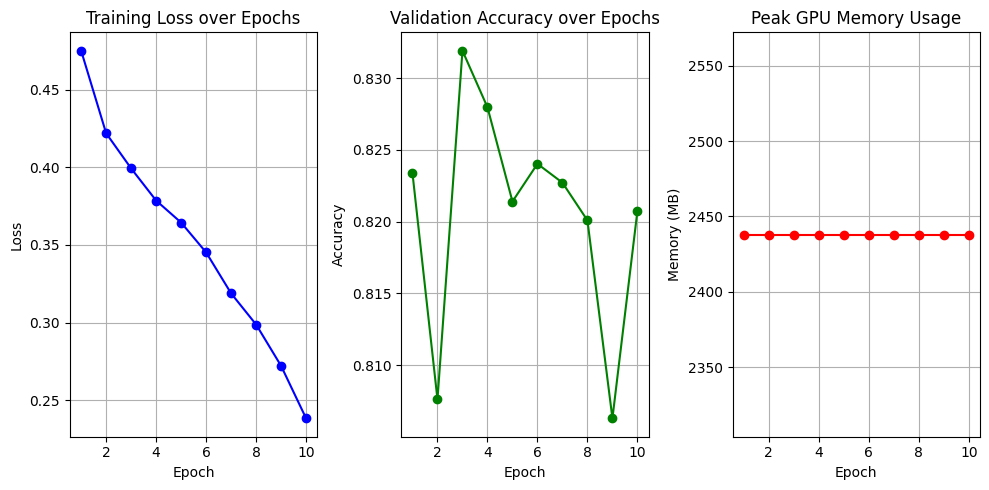

/home/ghufron/miniconda3/envs/homework2/lib/python3.11/site-packages/torch/cuda/memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(



üîç Training GRU


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [00:59<00:00,  3.19it/s]


Epoch 1 | Loss: 0.4644 | Val Acc: 0.8214


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [00:59<00:00,  3.20it/s]


Epoch 2 | Loss: 0.4055 | Val Acc: 0.8280


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [01:00<00:00,  3.18it/s]


Epoch 3 | Loss: 0.3842 | Val Acc: 0.8332


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [00:59<00:00,  3.20it/s]


Epoch 4 | Loss: 0.3550 | Val Acc: 0.8313


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [00:59<00:00,  3.19it/s]


Epoch 5 | Loss: 0.3337 | Val Acc: 0.8155


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [00:59<00:00,  3.21it/s]


Epoch 6 | Loss: 0.2973 | Val Acc: 0.8313


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [01:00<00:00,  3.18it/s]


Epoch 7 | Loss: 0.2661 | Val Acc: 0.8148


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [00:59<00:00,  3.20it/s]


Epoch 8 | Loss: 0.2375 | Val Acc: 0.8188


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [01:00<00:00,  3.18it/s]


Epoch 9 | Loss: 0.2063 | Val Acc: 0.7846


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 191/191 [00:59<00:00,  3.19it/s]


Epoch 10 | Loss: 0.1870 | Val Acc: 0.8181


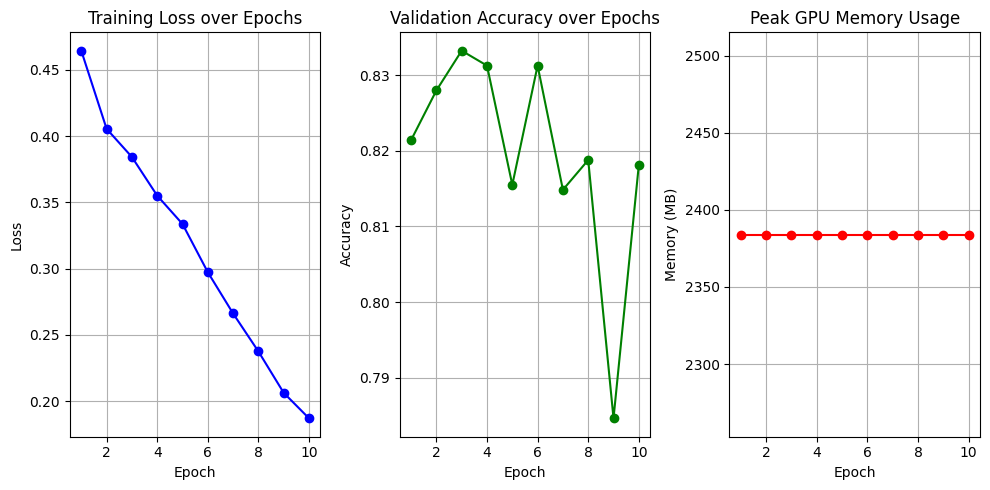

In [87]:
def run_experiment(rnn_type="lstm", num_epochs=10):
    # Clean memory before training
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.reset_max_memory_allocated()
    
    print(f"\nüîç Training {rnn_type.upper()}")
    model = LSTM_and_GRU_Classifier(rnn_type=rnn_type).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
    train_losses = []
    val_accuracies = []
    memory_usage = []

    for epoch in range(num_epochs):
        torch.cuda.reset_peak_memory_stats()
        train_loss = train(model, train_loader, optimizer, device)
        train_losses.append(train_loss)
        val_acc = evaluate(model, val_loader, device)
        val_accuracies.append(val_acc)
        peak_memory = torch.cuda.max_memory_reserved(device) / (1024 ** 2)  # In MB
        memory_usage.append(peak_memory)
        print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='b', label='Training Loss')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', color='g', label='Validation Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(range(1, num_epochs + 1), memory_usage, marker='o', color='red')
    plt.title("Peak GPU Memory Usage")
    plt.xlabel("Epoch")
    plt.ylabel("Memory (MB)")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model

LSTM_model = run_experiment("lstm")
GRU_model = run_experiment("gru")

we prepare to evaluate the trained models on a test dataset.

First, the test data is loaded from a CSV file along with the corresponding labels. A new column for labels is added to the test DataFrame. Then, a **TweetDataset** instance is created using the text and labels from the test DataFrame, and a DataLoader is initialized for efficient batch processing.

The evaluation of the LSTM model is performed using the `evaluate` function, which assesses its accuracy on the test set, with predictions printed out as specified. The process is repeated for the GRU model.

furthermore, the accuracies for both models are displayed, providing insight into their performance on unseen data.

In [ ]:

test_df = pd.read_csv("test.csv")       
test_ans = pd.read_csv("test_ans.csv") 
test_df = test_df.merge(test_ans, on='id')
test_df.rename(columns={"target": "label"}, inplace=True)

test_df['text'] = test_df['text'].apply(clean_tweet)

test_encodings = tokenize_text(test_df['text'])
test_dataset = TweetDataset(
    test_encodings,
    test_df['label'].tolist()
)
test_loader = DataLoader(test_dataset, batch_size=32)

print("Evaluating LSTM model on test set:")
lstm_acc = evaluate(LSTM_model, test_loader, device, True)
print(f"LSTM test Acc: {lstm_acc:.4f}")

print("Evaluating GRU model on test set:")
gru_acc = evaluate(GRU_model, test_loader, device, True)
print(f"GRU test Acc: {gru_acc:.4f}")

Evaluating LSTM model on test set:
üßæ Prediction Results:
Sample 1: Predicted = 1, Actual = 0
Sample 2: Predicted = 1, Actual = 0
Sample 3: Predicted = 1, Actual = 0
Sample 4: Predicted = 1, Actual = 0
Sample 5: Predicted = 1, Actual = 0
Sample 6: Predicted = 1, Actual = 0
Sample 7: Predicted = 0, Actual = 0
Sample 8: Predicted = 0, Actual = 0
Sample 9: Predicted = 0, Actual = 0
Sample 10: Predicted = 0, Actual = 0
Sample 11: Predicted = 0, Actual = 0
Sample 12: Predicted = 0, Actual = 0
Sample 13: Predicted = 0, Actual = 0
Sample 14: Predicted = 0, Actual = 0
Sample 15: Predicted = 0, Actual = 0
Sample 16: Predicted = 1, Actual = 0
Sample 17: Predicted = 0, Actual = 0
Sample 18: Predicted = 1, Actual = 0
Sample 19: Predicted = 0, Actual = 0
Sample 20: Predicted = 0, Actual = 0
Sample 21: Predicted = 0, Actual = 0
Sample 22: Predicted = 0, Actual = 0
Sample 23: Predicted = 0, Actual = 0
Sample 24: Predicted = 1, Actual = 0
Sample 25: Predicted = 0, Actual = 0
Sample 26: Predicted = 0